In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes, make_regression

In [2]:
eps = 1E-5
batch_size = 20

# learning rate
alpha = 0.01

# momentum parameter
gamma = 0.8

# Adagrad parameter 
delta = 0.9

# decay parameters for RMSProp and Adam
rho_s = 0.5
rho_r = 0.5

In [3]:
# load diabetes data
# data = load_diabetes()
# X = data['data']
# Y = data['target']

# make regression data
data = make_regression(n_samples=1000, n_features=10, random_state=42)
X = data[0]
Y = data[1]

logger = {}
X.shape, Y.shape

((1000, 10), (1000,))

The following are loss and gradient calculation functions. They do not change with optimizers.

In [4]:
def loss_fn(theta,X,Y):
    return (Y-X@theta).T @ (Y-X@theta)

def gradient(theta,X,Y):
    dtheta = 2 * X.T @ X @ theta - 2 * X.T @ Y 
    return theta

### 1. Gradient Descent

This is the most basic optimizer. Updates happen per epoch i.e. after all the examples have been seen. However, computing gradients can be computationally costly, time-consuming and can lead to memory issues as it's been done over the complete batch of data, we use Stochastic Gradient Descent which makes updates per batch and not per epoch.

In [5]:
def gradient_descent(theta_init, X, Y, alpha, eps):
    theta = theta_init
    dtheta = np.random.random(theta_init.shape)
    norm_thetas = []
    costs = []
    n_iter = 0

    while np.linalg.norm(dtheta)>eps:
        dtheta = gradient(theta,X,Y)
        theta -= alpha * dtheta
        cost = loss_fn(theta,X,Y)
        norm_thetas.append(np.linalg.norm(theta))
        costs.append(cost)
        n_iter += 1
        
    print(f'Converged in {n_iter} updates and {len(costs)} epochs..')
    return n_iter, norm_thetas, costs

### 2. Stochastic Gradient Descent

Here, updates are made per batch of data. The total number of updates are **n_epochs * n_batch_runs**, where n_batch_runs is the number of batch runs. However, since the updates are made per batch which is small fraction of complete data, the updates are noisy but are faster. This helps in speeding the optimizing process but can compromise on accuracy compared to Gradient Descent.

In Stochastic Gradient Descent, we have three variations:
1. **No Momentum** - Basic SGD
2. **Momentum** - As we know that the updates in SGD are noisy, fluctuating heavily in the search space, momentum uses Exponential Moving Averages of gradients from past iterations to overcome oscillations, thereby converging faster.
3. **Nestrov Momentum** - It has an added step over the momentum strategy that is to use theta updated interimly for calculating gradients.

In [6]:
def stochastic_gradient_descent(theta_init, vel_init, batch_size, X, Y, alpha, eps, gamma, momentum=False, nestrov=False):
    theta = theta_init
    vel = vel_init
    dtheta = np.random.random(theta_init.shape)
    
    norm_thetas = []
    costs = []
    n_iter = 0

    batch_run = int(len(X) / batch_size) + 1
    while np.linalg.norm(dtheta)>eps:
        for batch_idx in range(batch_run):
            X_batch = X[batch_size*batch_idx: min(batch_size*(batch_idx+1), len(X))]
            Y_batch = Y[batch_size*batch_idx: min(batch_size*(batch_idx+1), len(Y))]

            if not nestrov:
                dtheta = gradient(theta,X_batch,Y_batch)
                if momentum:
                    vel = gamma * vel - alpha * dtheta
                    theta += vel    
            else:
                theta += gamma * vel
                dtheta = gradient(theta,X_batch,Y_batch)
                vel = gamma * vel - alpha * dtheta
            theta -= alpha * dtheta                
            n_iter += 1
            
        cost = loss_fn(theta,X,Y)
        norm_thetas.append(np.linalg.norm(theta))
        costs.append(cost)
    print(f'Converged in {n_iter} updates and {len(costs)} epochs..')
    return n_iter, norm_thetas, costs

### 3. Adagrad

Consider a case if we are optimizing two variables such as weight (in kg) and height (in m). The ranges of these variables are significantly different i.e. weights would range 0-100 kg typically and heights would range 0-2 m typically. Optimizing these variables with the same learning rate is not the best idea because search spaces for variables are different and optimization within smaller search spaces can be done faster. 

Now in order to optimize these variables, we can do the following:

1. Normalize variables such that their ranges are similar, as done in **Batch Normalization**
2. Use different learning rates for different variables - **Adagrad**

Adagrad downscales learning rates based on historical gradient values.

In [7]:
def adagrad(theta_init, X, Y, alpha, eps, delta):
    theta = theta_init
    dtheta = np.random.random(theta_init.shape)
    norm_thetas = []
    costs = []
    n_iter = 0
    r = np.zeros(dtheta.shape)

    while np.linalg.norm(dtheta)>eps:
        dtheta = gradient(theta,X,Y)
        r+=(dtheta)**2
        theta -= np.multiply(alpha / (delta + np.sqrt(r)), dtheta)
        cost = loss_fn(theta,X,Y)
        norm_thetas.append(np.linalg.norm(theta))
        costs.append(cost)
        n_iter += 1
        
    print(f'Converged in {n_iter} updates and {len(costs)} epochs..')
    return n_iter, norm_thetas, costs

### 4. RMSProp

One of the problems that Adagrad faces is that the denominator can keep increasing leading to shallowing learning rate too much. RMSProp resolves this issue with exponential moving averages to weigh down past gradients as we move away from those.

In [8]:
def RMSProp(theta_init, X, Y, alpha, eps, delta, rho_r):
    theta = theta_init
    dtheta = np.random.random(theta_init.shape)
    norm_thetas = []
    costs = []
    n_iter = 0
    r = np.zeros(dtheta.shape)

    while np.linalg.norm(dtheta)>eps:
        dtheta = gradient(theta,X,Y)
        r = rho_r * r + (1-rho_r)*(dtheta)**2
        theta -= np.multiply(alpha / (delta + np.sqrt(r)), dtheta)
        cost = loss_fn(theta,X,Y)
        norm_thetas.append(np.linalg.norm(theta))
        costs.append(cost)
        n_iter += 1
        
    print(f'Converged in {n_iter} updates and {len(costs)} epochs..')
    return n_iter, norm_thetas, costs

### 5. Adam 
Adam is commonly seen as combination of RMSProp and Momentum. Incorporates exponential moving averages of first and second order moments which can be seen equivalent to Momentum and RMSProp strategy respectively.

In [9]:
def Adam(theta_init, X, Y, alpha, eps, delta, rho_s, rho_r):
    theta = theta_init
    dtheta = np.random.random(theta_init.shape)
    norm_thetas = []
    costs = []
    n_iter = 0
    s = np.zeros(dtheta.shape)
    r = np.zeros(dtheta.shape)

    while np.linalg.norm(dtheta)>eps:
        dtheta = gradient(theta,X,Y)
        s = rho_s * s + (1-rho_s) * dtheta
        r = rho_r * r + (1-rho_r) * dtheta * dtheta
        s = s / (1-rho_s)
        r = r / (1-rho_r)
        theta -= np.multiply(alpha * s / (delta + np.sqrt(r)), dtheta)
        cost = loss_fn(theta,X,Y)
        norm_thetas.append(np.linalg.norm(theta))
        costs.append(cost)
        n_iter += 1
        
    print(f'Converged in {n_iter} updates and {len(costs)} epochs..')
    return n_iter, norm_thetas, costs

In [10]:
def plotting(logger, var, methods):
    plt.title(var)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    for method in methods:
        plt.plot(logger[method][var], label=method)
    plt.legend()

In [11]:
def run(X, Y, alpha, gamma, delta, eps, rho_s, rho_r, batch_size, logger, method):
    theta_init = np.random.random(X.shape[1])
    vel_init = np.random.random(X.shape[1])
    
    print(f'\nRunning {method}..')
    # Gradient Descent
    if method=='Gradient Descent':
        n_iter, norm_thetas, costs = gradient_descent(theta_init, X, Y, alpha, eps)          
    
    # Stochastic (min-batch) gradient descent        
    elif method=='Stochastic Gradient Descent':
        n_iter, norm_thetas, costs = stochastic_gradient_descent(theta_init, vel_init, batch_size, X, Y, alpha, \
                                                                            eps, gamma, momentum=False, nestrov=False)
    
    # Stochastic gradient descent with Momentum        
    elif method=='Momentum':
        n_iter, norm_thetas, costs = stochastic_gradient_descent(theta_init, vel_init, batch_size, X, Y, alpha, \
                                                                            eps, gamma, momentum=True, nestrov=False)
    
    # Stochastic gradient descent with Nestrov Momentum         
    elif method=='Nestrov Momentum':
        n_iter, norm_thetas, costs = stochastic_gradient_descent(theta_init, vel_init, batch_size, X, Y, alpha, \
                                                                            eps, gamma, momentum=False, nestrov=True)

    # Adagrad         
    elif method=='Adagrad':
        n_iter, norm_thetas, costs = adagrad(theta_init, X, Y, alpha, eps, delta)
    
    # RMSProp        
    elif method=='RMSProp':
        n_iter, norm_thetas, costs = RMSProp(theta_init, X, Y, alpha, eps, delta, rho_r)
    
    # Adam        
    elif method=='Adam':
        n_iter, norm_thetas, costs = Adam(theta_init, X, Y, alpha, eps, delta, rho_s, rho_r) 
    
    # logging results       
    logger[method] = {}
    logger[method]['n_updates'] = n_iter
    logger[method]['norm_thetas'] = norm_thetas
    logger[method]['costs'] = costs                 

In [12]:
methods = ['Gradient Descent','Stochastic Gradient Descent','Momentum','Nestrov Momentum','Adagrad','RMSProp','Adam']
print('Initializing variables..')
for method in methods:
    run(X, Y, alpha, gamma, delta, eps, rho_s, rho_r, batch_size, logger, method=method)

Initializing variables..

Running Gradient Descent..
Converged in 1195 updates and 1195 epochs..

Running Stochastic Gradient Descent..
Converged in 1224 updates and 24 epochs..

Running Momentum..
Converged in 204 updates and 4 epochs..

Running Nestrov Momentum..
Converged in 255 updates and 5 epochs..

Running Adagrad..
Converged in 28759 updates and 28759 epochs..

Running RMSProp..
Converged in 1173 updates and 1173 epochs..

Running Adam..
Converged in 318 updates and 318 epochs..


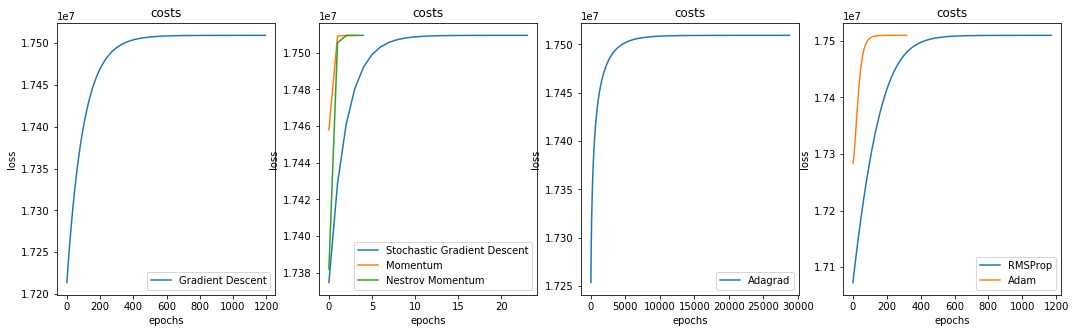

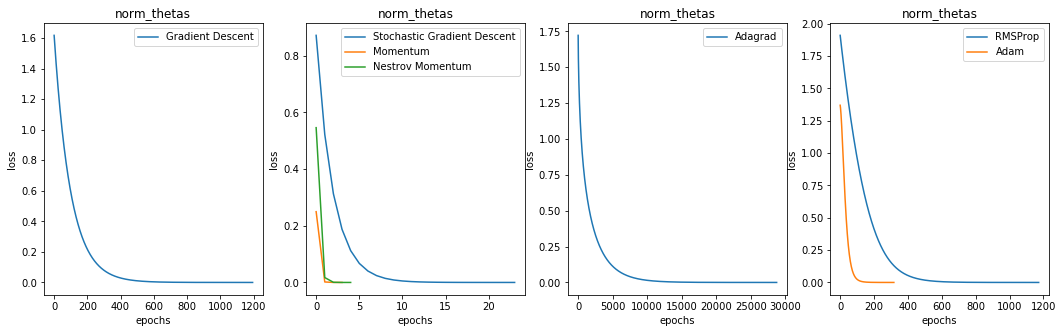

In [13]:
var = 'costs'
plt.figure(figsize=(18,5))
plt.subplot(141)
plotting(logger, var, methods=['Gradient Descent'])
plt.subplot(142)
plotting(logger, var, methods=['Stochastic Gradient Descent', 'Momentum', 'Nestrov Momentum'])
plt.subplot(143)
plotting(logger, var, methods=['Adagrad'])
plt.subplot(144)
plotting(logger, var, methods=['RMSProp','Adam'])
plt.show()

var = 'norm_thetas'
plt.figure(figsize=(18,5))
plt.subplot(141)
plotting(logger, var, methods=['Gradient Descent'])
plt.subplot(142)
plotting(logger, var, methods=['Stochastic Gradient Descent', 'Momentum', 'Nestrov Momentum'])
plt.subplot(143)
plotting(logger, var, methods=['Adagrad'])
plt.subplot(144)
plotting(logger, var, methods=['RMSProp','Adam'])
plt.show()

In [14]:
df = pd.DataFrame(columns=['optimizer','n_updates','n_epochs'])
for idx, method in enumerate(logger.keys()):
    df.loc[idx, 'optimizer'] = method
    df.loc[idx, 'n_updates'] = logger[method]['n_updates']
    df.loc[idx, 'n_epochs'] = len(logger[method]['costs'])

df = df.sort_values(by='n_epochs').reset_index(drop=True)
df

,optimizer,n_updates,n_epochs
0,Momentum,204,4
1,Nestrov Momentum,255,5
2,Stochastic Gradient Descent,1224,24
3,Adam,318,318
4,RMSProp,1173,1173
5,Gradient Descent,1195,1195
6,Adagrad,28759,28759
